In [1]:
from __future__ import print_function
import os; os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input
from keras import backend as K
from keras.models import load_model
import pickle
import pandas as pd
import re
import numpy as np
import random
from keras.utils.vis_utils import plot_model
import keras.callbacks
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import datasets, linear_model
import seaborn as sns
#from numpy.random import seed; seed(123)
#import tensorflow as tf; tf.random.set_seed(123)
from sklearn.metrics import roc_auc_score
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

Using TensorFlow backend.


In [2]:
##### load data #####
processed_data = pickle.load( open( "result_04_processed_data_no_scale_Final.obj", "rb" ) )
cytof_files = processed_data["cytof_files"]
cytof_files.to_csv("result_05_cytof_files.csv")
expr_list = processed_data["expr_list"]

r1 = [t1==t1 for t1 in cytof_files.CMV_Ab] 
cytof_files = cytof_files.loc[r1,:]
expr_list = expr_list[r1]#[expr_list[i] for i in range(len(expr_list)) if r1[i]==True]
print(expr_list.shape)

(532, 10000, 27, 1)


In [3]:
y = cytof_files.CMV_Ab.values> 2
x = expr_list

In [4]:
##### split train, validation and test######
train_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i] not in ["SDY515","SDY519"]]
valid_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i]=="SDY515"]
test_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i]=="SDY519"]

x_train = x[train_id]
x_valid = x[valid_id]
x_test = x[test_id]

y_train = y[train_id]
y_valid = y[valid_id]
y_test = y[test_id]

In [5]:
best_model = load_model('Final_weights.hdf5')

# print result of the best model
score = best_model.evaluate([x_train], y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = best_model.evaluate([x_valid], y_valid, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

score = best_model.evaluate([x_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.4089998901785315
Train accuracy: 0.8588588833808899
Valid loss: 0.5623397683795495
Valid accuracy: 0.7341772317886353
Test loss: 0.5425303181012472
Test accuracy: 0.7333333492279053


In [6]:
y_true = y_test
y_scores = best_model.predict([x_test])
print(roc_auc_score(y_true, y_scores))

y_true = y_train
y_scores = best_model.predict([x_train])
print(roc_auc_score(y_true, y_scores))

y_true = y_valid
y_scores = best_model.predict([x_valid])
print(roc_auc_score(y_true, y_scores))


0.9434523809523809
0.9204791456198586
0.8184754521963824


In [7]:
pred = np.zeros([120,10000])
s1 = np.random.randint(0,9999,500)

for i in range(120):
    pred_i = best_model.predict([x_test[[i],:,:,:]])
    for j in range(10000):
        t1 = x_test[[i],:,:,:].copy()
        t1[:,s1,:,:] = t1[:,j,:,:]
        pred_j = best_model.predict([t1])
        pred[i,j] = pred_j-pred_i
        

In [8]:
pred = pred.reshape([120*10000])

#pred  = (pred-np.mean(pred))/np.std(pred)
x_test2 = x_test.reshape([120*10000,27])

(array([1.88000e+02, 2.84100e+03, 2.90920e+04, 1.94201e+05, 7.13611e+05,
        2.08419e+05, 4.35610e+04, 7.16400e+03, 8.67000e+02, 5.60000e+01]),
 array([-0.55049276, -0.42942408, -0.3083554 , -0.18728672, -0.06621804,
         0.05485064,  0.17591932,  0.296988  ,  0.41805668,  0.53912536,
         0.66019404]),
 <a list of 10 Patch objects>)

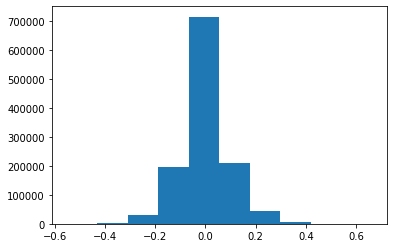

In [9]:
plt.hist(pred)

In [23]:
r2 = pd.DataFrame({"depth":range(1,11),"r2":np.zeros(10),"max":np.zeros(10),"mse":np.zeros(10)})
for i in range(r2.shape[0]):
    regr_1 = DecisionTreeRegressor(max_depth=i+1,min_samples_leaf=0.01)
    #score = cross_validate(regr_1, x_test2[0,:,:,0], pred, cv=10,scoring='explained_variance')
    regr_1.fit(x_test2, pred)
    t1 = regr_1.predict(x_test2)
    mse = (np.square(t1 - pred)).mean(axis=None)
    score = np.corrcoef(t1,pred)[0,1]
    r2.at[i,"r2"] = score#/np.var(pred)*100##np.mean(score['test_score'])#
    r2.at[i,"max"]=max(t1)
    r2.at[i,"mse"]=mse

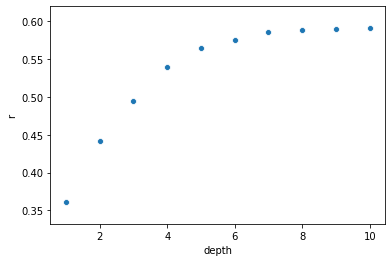

In [29]:
r2["r"] = np.sqrt(r2["r2"])
p1 = sns.scatterplot(x="depth", y="r", data=r2)
fig = p1.get_figure()
fig.savefig("result_06_elbow.pdf") 

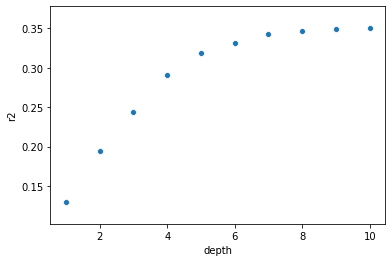

In [12]:
# # sample 10,000 cell from test dataset
# x_test2 = np.zeros([1,10000,27,1])
# for i in range(10000):
#     i1 = random.randint(0, 119)
#     i2 = random.randint(0, 9999)
#     x_test2[0,i,:,:] = x_test[i1,i2,:,:]


In [13]:
# pred = np.zeros(10000)
# for i in range(10000):
#     s1 = np.random.randint(0,9999,500)
#     t1 = x_test2.copy()
#     t1[:,s1,:,:] = x_test2[:,i,:,:]
#     pred[i] = best_model.predict([t1])
    
# pred2 = np.zeros(10000)
# for i in range(10000):
#     s1 = np.random.randint(0,9999,100)
#     t1 = x_test2.copy()
#     t1[:,s1,:,:] = x_test2[:,i,:,:]
#     pred2[i] = best_model.predict([t1])

In [14]:
# np.corrcoef(pred, pred2)

In [15]:
# r2 = pd.DataFrame({"depth":range(1,21),"score":np.zeros(20)})
# for i in range(r2.shape[0]):
#     regr_1 = DecisionTreeRegressor(max_depth=i+1,min_samples_leaf=0.01)
#     #score = cross_validate(regr_1, x_test2[0,:,:,0], pred, cv=10,scoring='explained_variance')
#     regr_1.fit(x_test2[0,:,:,0], pred)
#     t1 = regr_1.predict(x_test2[0,:,:,0])
#     #score = (np.square(t1 - pred)).mean(axis=None)
#     #score = np.corrcoef(t1,pred)[0,1]
#     r2.at[i,"score"] = max(t1)#np.mean(score['test_score'])#/np.var(pred)*100

# sns.scatterplot(x="depth", y="score", data=r2)

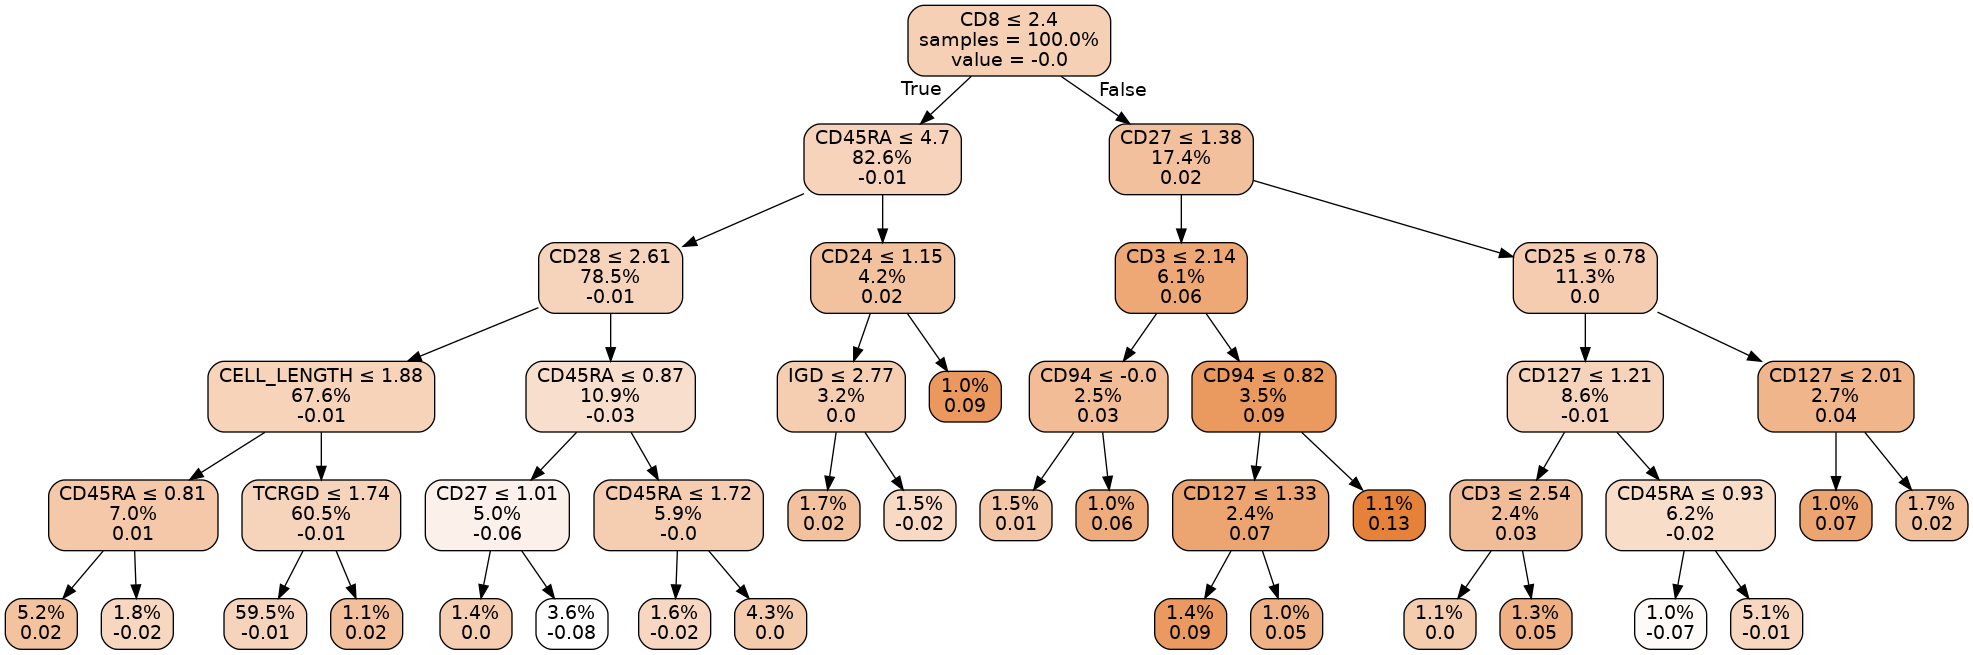

In [26]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
 
regr_1 = DecisionTreeRegressor(max_depth=4,min_samples_leaf=0.01)
regr_1.fit(x_test2, pred)

dot_data = StringIO()
export_graphviz(regr_1, out_file=dot_data, 
                feature_names= processed_data["marker_names"],
                filled=True, rounded=True,proportion=True,impurity=False,
                special_characters=True,precision=2,label="root")
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("result_06_decision_tree.pdf") 
Image(graph.create_png())

Ttest_indResult(statistic=6.2971676317125205, pvalue=1.3995571572643172e-07)

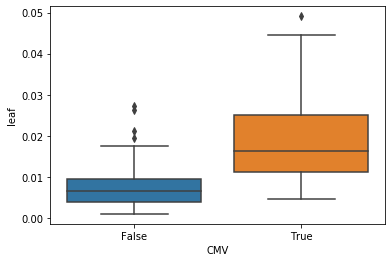

In [17]:
X2=x_test.reshape(x_test.shape[0]*x_test.shape[1],x_test.shape[2])
pred2 = regr_1.predict(X=X2)
leaf = regr_1.apply(X2)
max_leaf = [leaf[np.argmax(pred2)]]
leaf = np.isin(leaf,max_leaf)

leaf = leaf.reshape(x_test.shape[0],x_test.shape[1])
leaf = np.mean(leaf, 1)
leaf_CMV = pd.DataFrame({"leaf":leaf,"CMV":y_test})
sns.boxplot(x="CMV", y="leaf", data=leaf_CMV)
ttest_ind(leaf_CMV.leaf[leaf_CMV.CMV==1],
         leaf_CMV.leaf[leaf_CMV.CMV==0], 
         equal_var = False)

In [37]:
k = 100
pred = np.zeros([120,k])
pred2 = np.zeros([120,k])
s1 = np.random.randint(0,9999,500)


for i in range(120):
    pred_i = best_model.predict([x_test[[i],:,:,:]])
    for j in range(k):
        t1 = x_test[[i],:,:,:].copy()
        t1[:,s1,:,:] = t1[:,s1[j],:,:]
        pred_j = best_model.predict([t1])
        pred[i,j] = pred_j-pred_i
        
for i in range(120):
    pred_i = best_model.predict([x_test[[i],:,:,:]])
    for j in range(k):
        t1 = x_test[[i],:,:,:].copy()
        t1[:,s1[0:99],:,:] = t1[:,s1[j],:,:]
        pred_j = best_model.predict([t1])
        pred2[i,j] = pred_j-pred_i

pred = pred.reshape([120*k])
pred2 = pred2.reshape([120*k])
p1 = pd.DataFrame({"pred":pred,"pred2":pred2})

In [49]:
sns.regplot("pred", "pred2", data = p1,
            scatter_kws={'alpha':0.1},
           edgecolors=None)
np.corrcoef(pred, pred2)

TypeError: regplot() got an unexpected keyword argument 'edgecolors'

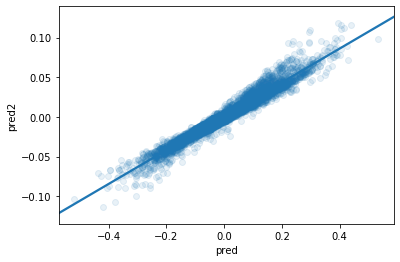